In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.transforms import RandAugment
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt

# Paths
DATA_DIR = '/content/drive/MyDrive/ad'
CACHE_PATH = '/content/drive/MyDrive/balanced_ad_1200.pt'
TARGET_COUNT = 1200
NUM_CLASSES = 4
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# Transforms
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

augment_transform = transforms.Compose([
    RandAugment(num_ops=2, magnitude=7),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class BalancedDataset(Dataset):
    def __init__(self, dataset, target_count=1200, transform=None, augment=None):
        self.data = []
        self.labels = []
        self.classes = dataset.classes
        self.transform = transform
        self.augment = augment

        # Group by class
        class_to_images = {i: [] for i in range(len(self.classes))}
        for img_path, label in dataset.samples:
            class_to_images[label].append(img_path)

        for label, img_paths in class_to_images.items():
            imgs = img_paths.copy()
            count = len(imgs)

            if count > target_count:
                imgs = random.sample(imgs, target_count)
            elif count < target_count:
                extra_needed = target_count - count
                extra_imgs = random.choices(imgs, k=extra_needed)
                imgs += extra_imgs

            for img_path in imgs:
                img = Image.open(img_path).convert('RGB')
                if count < target_count and img_path in extra_imgs:
                    img = self.augment(img)
                else:
                    img = self.transform(img)
                self.data.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# Load original dataset
raw_dataset = datasets.ImageFolder(DATA_DIR)

# Create balanced dataset
balanced_dataset = BalancedDataset(
    dataset=raw_dataset,
    target_count=TARGET_COUNT,
    transform=base_transform,
    augment=augment_transform
)

# # Save the dataset
# torch.save({
#     'data': balanced_dataset.data,
#     'labels': balanced_dataset.labels,
#     'classes': raw_dataset.classes
# }, CACHE_PATH)

print(f"✅ Saved balanced dataset with {len(balanced_dataset)} samples to: {CACHE_PATH}")
# Load class names
class_names = raw_dataset.classes

# Plot examples from the balanced dataset
def show_examples(dataset, num_per_class=3):
    fig, axs = plt.subplots(NUM_CLASSES, num_per_class, figsize=(num_per_class*3, NUM_CLASSES*3))
    shown = {i: 0 for i in range(NUM_CLASSES)}

    for img, label in dataset:
        if shown[label] < num_per_class:
            ax = axs[label][shown[label]]
            ax.imshow(img.permute(1, 2, 0))
            ax.set_title(f"{class_names[label]}")
            ax.axis('off')
            shown[label] += 1

        if all(shown[i] >= num_per_class for i in range(NUM_CLASSES)):
            break

    plt.tight_layout()
    plt.show()

show_examples(balanced_dataset)


In [ ]:
# Load your balanced dataset
# Assuming 'balanced_data' contains your image data as a numpy array and 'balanced_labels' as corresponding labels.
balanced_data = torch.load('/content/drive/MyDrive/balanced_ad_1200.pt')['data']  # Load the tensor
balanced_labels = torch.load('/content/drive/MyDrive/balanced_ad_1200.pt')['labels']  # Load the labels

# Convert balanced_data and balanced_labels to tensors if they are not already
balanced_data = torch.tensor(balanced_data) if not isinstance(balanced_data, torch.Tensor) else balanced_data
balanced_labels = torch.tensor(balanced_labels) if not isinstance(balanced_labels, torch.Tensor) else balanced_labels

# Create a TensorDataset
dataset = TensorDataset(balanced_data, balanced_labels)


In [ ]:
print(type(balanced_data))
print(type(balanced_labels))
print(balanced_data.shape if hasattr(balanced_data, 'shape') else len(balanced_data))
print(len(balanced_labels))


<class 'list'>
<class 'list'>
4800
4800


<ipython-input-8-51d6602ea713>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(data).float()  # Convert each image to a tensor


torch.Size([4800, 3, 224, 224])
torch.Size([4800])


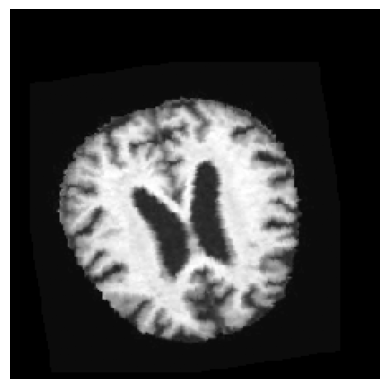

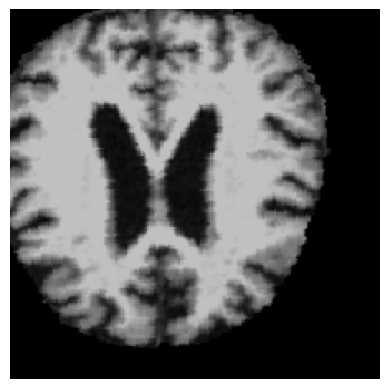

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchvision.utils import make_grid
from PIL import Image

# Assuming balanced_data is a list of image data and balanced_labels is a list of corresponding labels.
# Let's first convert these lists into tensors.

def list_to_tensor(data_list):
    tensor_list = []
    for data in data_list:
        img_tensor = torch.tensor(data).float()  # Convert each image to a tensor
        tensor_list.append(img_tensor)
    return torch.stack(tensor_list)

balanced_data_tensor = list_to_tensor(balanced_data)  # Convert list to tensor
balanced_labels_tensor = torch.tensor(balanced_labels).long()  # Convert labels to tensor

print(balanced_data_tensor.shape)  # Check the shape of the tensor
print(balanced_labels_tensor.shape)  # Check the shape of the labels tensor

# Define your transformations for augmentation
transform_weak = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
])

transform_strong = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.RandomRotation(45),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.7, 1.3)),
])

# Create a Dataset using the balanced data and labels
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform_weak=None, transform_strong=None):
        self.images = images
        self.labels = labels
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Convert tensor to PIL image for transformation
        img_pil = transforms.ToPILImage()(img)

        # Apply the transformations
        img_weak = self.transform_weak(img_pil) if self.transform_weak else img
        img_strong = self.transform_strong(img_pil) if self.transform_strong else img

        # Convert back to tensor after augmentation
        img_weak = transforms.ToTensor()(img_weak)
        img_strong = transforms.ToTensor()(img_strong)

        return img_weak, img_strong, label

# Create dataset and dataloaders
dataset = CustomDataset(balanced_data_tensor, balanced_labels_tensor, transform_weak, transform_strong)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Visualize augmentation effects by showing a few augmented images
def show_image(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert tensor to numpy for visualization
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Sample some images to visualize the augmentations
for i, (img_weak, img_strong, label) in enumerate(dataloader):
    if i == 1:  # Show 2nd batch
        show_image(img_weak[0])  # Show first weak augmented image
        show_image(img_strong[0])  # Show first strong augmented image
        break


<ipython-input-9-4489c21be144>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(data).float()  # Convert each image to a tensor


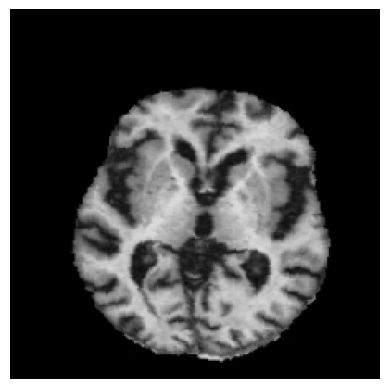

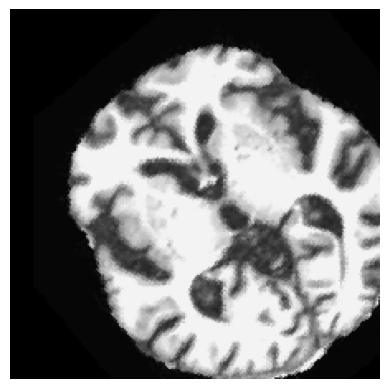

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s] 


ValueError: too many values to unpack (expected 2)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.utils import make_grid
from PIL import Image
import os

# Set random seed for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# 1. Data Loading and Augmentation
# ------------------------------
def list_to_tensor(data_list):
    tensor_list = []
    for data in data_list:
        img_tensor = torch.tensor(data).float()  # Convert each image to a tensor
        tensor_list.append(img_tensor)
    return torch.stack(tensor_list)

# Load the balanced dataset (assuming it's already prepared)
balanced_data_tensor = list_to_tensor(balanced_data)  # Convert list to tensor
balanced_labels_tensor = torch.tensor(balanced_labels).long()  # Convert labels to tensor

# Define transformations
transform_weak = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
])

transform_strong = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.RandomRotation(45),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.7, 1.3)),
])

# Dataset class to handle the augmentations
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform_weak=None, transform_strong=None):
        self.images = images
        self.labels = labels
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Convert tensor to PIL image for transformation
        img_pil = transforms.ToPILImage()(img)

        # Apply transformations
        img_weak = self.transform_weak(img_pil) if self.transform_weak else img
        img_strong = self.transform_strong(img_pil) if self.transform_strong else img

        # Convert back to tensor after augmentation
        img_weak = transforms.ToTensor()(img_weak)
        img_strong = transforms.ToTensor()(img_strong)

        return img_weak, img_strong, label

# Create dataset and dataloaders
dataset = CustomDataset(balanced_data_tensor, balanced_labels_tensor, transform_weak, transform_strong)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Function to visualize images
def show_image(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert tensor to numpy for visualization
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Sample some images to visualize the augmentations
for i, (img_weak, img_strong, label) in enumerate(dataloader):
    if i == 1:  # Show 2nd batch
        show_image(img_weak[0])  # Show first weak augmented image
        show_image(img_strong[0])  # Show first strong augmented image
        break

# ------------------------------
# 2. Model Setup
# ------------------------------
class EfficientNetForCIFAR10(nn.Module):
    def __init__(self):
        super(EfficientNetForCIFAR10, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 10)

    def forward(self, x):
        return self.model(x)

# ------------------------------
# 3. Training Procedure
# ------------------------------
def train_fixmatch(model, labeled_loader, unlabeled_loader, start_epoch=0, epochs=10, threshold=0.95):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    epoch_losses = []

    for epoch in range(start_epoch, epochs):
        total_loss = 0
        model.train()

        for (inputs_x, targets_x), (inputs_u_weak, inputs_u_strong) in zip(labeled_loader, unlabeled_loader):
            inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
            inputs_u_weak, inputs_u_strong = inputs_u_weak.to(device), inputs_u_strong.to(device)

            outputs_x = model(inputs_x)
            loss_x = criterion(outputs_x, targets_x)

            with torch.no_grad():
                outputs_u_weak = model(inputs_u_weak)
                probs = torch.softmax(outputs_u_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(threshold).float()

            outputs_u_strong = model(inputs_u_strong)
            loss_u = (criterion(outputs_u_strong, pseudo_labels) * mask).mean()

            loss = loss_x + loss_u
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(labeled_loader)
        epoch_losses.append(avg_loss)

        # Save checkpoint at the end of each epoch
        checkpoint_dir = "/content/drive/MyDrive/fixmatch_checkpoints"
        os.makedirs(checkpoint_dir, exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth"))

    return epoch_losses

# ------------------------------
# 4. Evaluation
# ------------------------------
def evaluate(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

# ------------------------------
# 5. Run Everything
# ------------------------------
model = EfficientNetForCIFAR10()

# Create data loaders for labeled and unlabeled data (this part should be adapted to your dataset split)
labeled_loader = DataLoader(dataset, batch_size=64, shuffle=True)
unlabeled_loader = DataLoader(dataset, batch_size=64, shuffle=True)  # Replace with your actual unlabeled data

# Train and evaluate the model
epochs = 10
losses = train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=epochs)
evaluate(model, labeled_loader)

# Plot loss vs epoch
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid()
plt.show()


Starting from scratch.
Epoch [1/10] Loss: 1.5709
Epoch [2/10] Loss: 1.3683
Epoch [3/10] Loss: 1.3690
Epoch [4/10] Loss: 1.2798
Epoch [5/10] Loss: 1.2288
Epoch [6/10] Loss: 1.2417
Epoch [7/10] Loss: 1.1124
Epoch [8/10] Loss: 1.1991
Epoch [9/10] Loss: 1.0909
Epoch [10/10] Loss: 1.0555
Accuracy: 56.46%


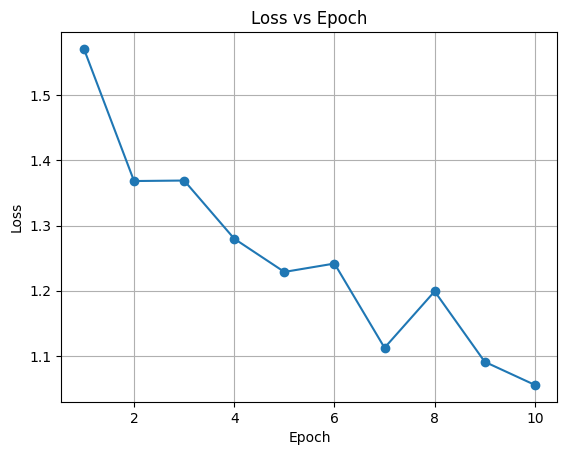

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.models import efficientnet_b0
from PIL import Image

# ----------------------------
# 1. Set seed and device
# ----------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# 2. Load your balanced dataset
# ----------------------------
data_path = "/content/drive/MyDrive/balanced_ad_1200.pt"
data_dict = torch.load(data_path)
data = data_dict['data']
labels = data_dict['labels']

data = torch.stack([img.clone().detach() if isinstance(img, torch.Tensor) else torch.tensor(img).float() for img in data])
labels = torch.tensor(labels)

# ----------------------------
# 3. Augmentations
# ----------------------------
transform_weak = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
])

transform_strong = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomAffine(degrees=30),
    transforms.RandomCrop(224, padding=4),
])

# ----------------------------
# 4. Dataset Class with Augmentations
# ----------------------------
class FixMatchDataset(Dataset):
    def __init__(self, data, labels, weak_aug, strong_aug):
        self.data = data
        self.labels = labels
        self.weak_aug = weak_aug
        self.strong_aug = strong_aug

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        img = transforms.ToPILImage()(img)
        img_weak = self.weak_aug(img)
        img_strong = self.strong_aug(img)
        return transforms.ToTensor()(img_weak), transforms.ToTensor()(img_strong), label

# ----------------------------
# 5. Prepare Dataloaders
# ----------------------------
split = int(0.1 * len(data))
indices = torch.randperm(len(data))
labeled_idx = indices[:split]
unlabeled_idx = indices[split:]

labeled_dataset = FixMatchDataset(data[labeled_idx], labels[labeled_idx], transform_weak, transform_strong)
unlabeled_dataset = FixMatchDataset(data[unlabeled_idx], labels[unlabeled_idx], transform_weak, transform_strong)

labeled_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)

# ----------------------------
# 6. EfficientNet Model
# ----------------------------
class EfficientNetForClassification(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.backbone = efficientnet_b0(weights=None)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# ----------------------------
# 7. Load Checkpoint (Resume)
# ----------------------------
checkpoint_dir = "/content/drive/MyDrive/fixmatch_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

def get_latest_checkpoint(directory):
    checkpoints = [f for f in os.listdir(directory) if f.endswith(".pth")]
    if not checkpoints:
        return None
    checkpoints.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))
    return os.path.join(directory, checkpoints[-1])

latest_ckpt = get_latest_checkpoint(checkpoint_dir)
start_epoch = 0

model = EfficientNetForClassification(num_classes=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

if latest_ckpt:
    print(f"Resuming from: {latest_ckpt}")
    checkpoint = torch.load(latest_ckpt, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
else:
    print("Starting from scratch.")

# ----------------------------
# 8. Training and Evaluation
# ----------------------------
def train_fixmatch(model, labeled_loader, unlabeled_loader, start_epoch=0, epochs=10, threshold=0.95):
    model.train()
    criterion = nn.CrossEntropyLoss()
    all_losses = []

    for epoch in range(start_epoch, epochs):
        total_loss = 0
        for (x_w, x_s, y_l), (u_w, u_s, _) in zip(labeled_loader, unlabeled_loader):
            x_w, x_s, y_l = x_w.to(device), x_s.to(device), y_l.to(device)
            u_w, u_s = u_w.to(device), u_s.to(device)

            # Supervised loss
            logits_x = model(x_w)
            loss_x = criterion(logits_x, y_l)

            # Unsupervised loss
            with torch.no_grad():
                pseudo_labels = torch.softmax(model(u_w), dim=1)
                max_probs, targets_u = torch.max(pseudo_labels, dim=1)
                mask = max_probs.ge(threshold).float()

            logits_u = model(u_s)
            loss_u = (criterion(logits_u, targets_u) * mask).mean()

            # Combine losses
            loss = loss_x + loss_u
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(labeled_loader)
        all_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f"ckpt_{epoch}.pth")
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }, checkpoint_path)

    return all_losses

def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x_w, _, y in loader:
            x_w, y = x_w.to(device), y.to(device)
            preds = torch.argmax(model(x_w), dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    print(f"Accuracy: {100 * correct / total:.2f}%")

# ----------------------------
# 9. Run Training and Evaluation
# ----------------------------
losses = train_fixmatch(model, labeled_loader, unlabeled_loader, start_epoch=start_epoch, epochs=10)
evaluate(model, labeled_loader)

# Plot loss vs epoch
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid()
plt.show()


In [1]:
!git config --global user.email "sadiatahsin3.1415@gmail.com"
!git config --global user.name "sadia-tahsin"
!git clone https://github.com/sadia-tahsin/IDT-project2-SSL.git


Cloning into 'IDT-project2-SSL'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 1.76 MiB | 21.49 MiB/s, done.


In [2]:
!cp /content/drive/MyDrive/Colab_Notebooks/fixmatch-alzhemier.ipynb /content/IDT-project2-SSL/
%cd /content/IDT-project2-SSL/

cp: cannot stat '/content/drive/MyDrive/Colab_Notebooks/fixmatch-alzhemier.ipynb': No such file or directory
/content/IDT-project2-SSL
